# Hw4 of Applied Machine Learning

### Shuai Hao (sh3831), Eugene M. Joseph (emj2152)

## Predict wine quality from review texts
This notebook explores simple ngram model using [the wine reviews data](https://www.kaggle.com/zynicide/wine-reviews) from Kaggle. The data were scraped on November 22nd, 2017. For this task, only the wine from the US are used.

## Task 1 Bag of Words and simple Features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from operator import itemgetter
from category_encoders import TargetEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer, KNNImputer 
import seaborn as sns

In [2]:
df_all = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)

In [3]:
df = df_all[df_all["country"] == "US"]

In [4]:
df

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129945,US,Hailing from one of the more popular vineyards...,Jurassic Park Vineyard Old Vines,90,20.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,@mattkettmann,Birichino 2013 Jurassic Park Vineyard Old Vine...,Chenin Blanc,Birichino
129949,US,There's no bones about the use of oak in this ...,Barrel Fermented,90,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Flora Springs 2013 Barrel Fermented Chardonnay...,Chardonnay,Flora Springs
129950,US,This opens with herbaceous dollops of thyme an...,Blocks 7 & 22,90,35.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Hendry 2012 Blocks 7 & 22 Zinfandel (Napa Valley),Zinfandel,Hendry
129952,US,This Zinfandel from the eastern section of Nap...,NaN,90,22.0,California,Chiles Valley,Napa,Virginie Boone,@vboone,Houdini 2011 Zinfandel (Chiles Valley),Zinfandel,Houdini


Let's explore the data first

In [5]:
continuous_cols = df.dtypes != 'object'
continuous = df.columns[continuous_cols].to_list()

categorical_cols = df.dtypes == 'object'
categorical = df.columns[categorical_cols].to_list()

In [6]:
continuous

['points', 'price']

In [7]:
categorical

['country',
 'description',
 'designation',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'taster_twitter_handle',
 'title',
 'variety',
 'winery']

In [8]:
print("Percentage of missing values per column (%):")
print(df.isna().sum()/len(df)*100)

Percentage of missing values per column (%):
country                   0.000000
description               0.000000
designation              32.283869
points                    0.000000
price                     0.438500
province                  0.000000
region_1                  0.510054
region_2                  7.326068
taster_name              30.775723
taster_twitter_handle    36.259724
title                     0.000000
variety                   0.000000
winery                    0.000000
dtype: float64


In [9]:
print("Number of unique entries per categorical column")
df[categorical].nunique()

Number of unique entries per categorical column


country                      1
description              50449
designation              14183
province                    27
region_1                   264
region_2                    17
taster_name                 15
taster_twitter_handle       12
title                    50229
variety                    257
winery                    5375
dtype: int64

In [10]:
print("List all unique value for feature 'taster_name'")
df['taster_name'].unique()

List all unique value for feature 'taster_name'


array(['Paul Gregutt', 'Alexander Peartree', 'Virginie Boone',
       'Matt Kettmann', nan, 'Sean P. Sullivan', 'Jim Gordon',
       'Anna Lee C. Iijima', 'Susan Kostrzewa', 'Roger Voss',
       'Carrie Dykes', 'Fiona Adams', 'Michael Schachner',
       'Joe Czerwinski', 'Lauren Buzzeo', 'Christina Pickard'],
      dtype=object)

In [11]:
print("List all unique value for feature 'taster_twitter_handle'")
df['taster_twitter_handle'].unique()

List all unique value for feature 'taster_twitter_handle'


array(['@paulgwine\xa0', nan, '@vboone', '@mattkettmann', '@wawinereport',
       '@gordone_cellars', '@suskostrzewa', '@vossroger', '@bkfiona',
       '@wineschach', '@JoeCz', '@laurbuzz', '@winewchristina'],
      dtype=object)

Let's also try out the Pandas Profiling feature

In [12]:
pip install pandas-profiling

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
from pandas_profiling import ProfileReport

In [14]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [15]:
profile.to_notebook_iframe()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [ ]:
profile.to_widgets()

In [ ]:
profile.to_file(output_file="Task1_PandasProfilingReport.html")

Just in case the pandas profiling report does not show up rendered, we've attached it as an html file for reference. 

### 1.1 Create a baseline model for predicting wine quality using only non-text features.

The features **description** and **title** are text features describing the wine quality, so we dropped them for this task.

The feature **country** is the same for every record, so we also dropped it.

The feature **taster_twitter_handle** is highly correlated to **taster_name** and has more missing values, so we dropped **taster_twitter_handle**.

In [16]:
y = df['points']

In [17]:
X = df.drop(columns=['country','points','description', 'title', 'taster_twitter_handle'])

In [ ]:
X = df.drop(columns=['country','points','description', 'title', 'taster_twitter_handle'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [19]:
categorical = X_train.dtypes == 'object'

In [20]:
preprocess_continuous = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
preprocess_target = make_pipeline(
    TargetEncoder(),
)
preprocess_dummy = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore')
)

In [34]:
preprocess = make_column_transformer(
    (preprocess_continuous, ~categorical),
    (preprocess_target, ['designation', 'winery']),
    (preprocess_dummy, ['region_1', 'region_2', 'taster_name', 'province','variety']))

In [30]:
model_linear_regression = make_pipeline(preprocess, LinearRegression())

In [31]:
scores = cross_val_score(model_linear_regression, X_train, y_train)
np.mean(scores)

0.4600954219803417

In [32]:
model_linear_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                           

In [33]:
model_linear_regression.score(X_test, y_test)

0.4628053285559246

So using a simple linear model without text features we've obtained a cross validation score of **0.46** and a test score of **0.463**

### 1.2 Create a simple text-based model using a bag-of-words approach and a linear model.

In [17]:
y = df['points']

In [18]:
X = df[['description', 'title']]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [20]:
proprocess_word = make_pipeline(
    CountVectorizer()
)

In [21]:
preprocess = make_column_transformer(
    (proprocess_word, 'description'),
    (proprocess_word, 'title')
)

In [22]:
model_linear_regression = make_pipeline(preprocess, LinearRegression())

In [23]:
scores = cross_val_score(model_linear_regression, X_train, y_train)
np.mean(scores)

0.13141355619293188

In [24]:
model_linear_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('countvectorizer',
                                                                   CountVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.int64'>,
                                                                                   encoding='utf-8',
                  

In [25]:
model_linear_regression.score(X_test, y_test)

0.403013592537682

We received a relatively low cross validation score of **0.13** and a test score of **0.4**. Note that we had separate count vectorizers for the description and title features. We'll try concatenating them both into a single all-text feature so we can reduce the number of vectors produced.

### 1.3 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. 
Be aware that you might need to adjust the (regularization of the) linear model for
different feature sets.

Let's concatenate the text from the title and description into one column that we can run our vectorizers on

In [50]:
df['all_text'] = df['title'].astype(str) + " " +df['description'].astype(str)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
y = df['points']

In [52]:
X = df[['all_text']]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [57]:
proprocess_word = make_pipeline(
    CountVectorizer(),
    TfidfTransformer()
)

In [58]:
preprocess = make_column_transformer(
    (proprocess_word, 'all_text'),
)

In [59]:
model_linear_regression = make_pipeline(preprocess, LinearRegression())

In [60]:
scores = cross_val_score(model_linear_regression, X_train, y_train)
np.mean(scores)

0.4332815162289673

In [61]:
model_linear_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('countvectorizer',
                                                                   CountVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.int64'>,
                                                                                   encoding='utf-8',
                    

In [62]:
model_linear_regression.score(X_test, y_test)

0.5487287504625489

Treating the text features as one column greatly increased our score so we'll continue doing that for the remainder of this section

Classic GridSearch (ie. not using char or char_wb).  
From our experiments we found that using the sklearn in-built stopwords just reduced our scores so we decided not to use them. 

In [65]:
proprocess_word = make_pipeline(
    CountVectorizer(),
    TfidfTransformer()
)

preprocess = make_column_transformer(
    (proprocess_word, 'all_text'),
)

In [66]:
pipe = Pipeline([('preprocessor', preprocess), ('normalizer', Normalizer()), ('regressor', LinearRegression())])
param_grid = [
    {
      "preprocessor__pipeline__countvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
      "preprocessor__pipeline__countvectorizer__min_df": [1, 2, 3, 4],
      "normalizer": [None, Normalizer()]
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)  
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('countvectorizer',
                                                                                          CountVectorizer(analyzer='word',
                                                                                                          binary=False,
                    

In [68]:
grid.best_score_

0.7496049144748869

In [69]:
grid.best_params_

{'normalizer': None,
 'preprocessor__pipeline__countvectorizer__min_df': 1,
 'preprocessor__pipeline__countvectorizer__ngram_range': (1, 2)}

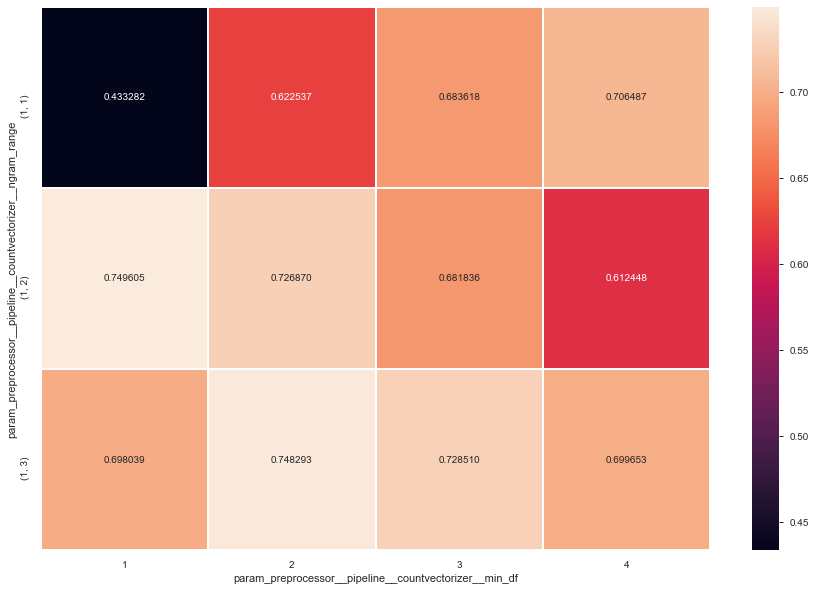

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df_grid = pd.DataFrame(grid.cv_results_).round(6)
df_grid
res = pd.pivot_table(df_grid,
    values='mean_test_score', index='param_preprocessor__pipeline__countvectorizer__ngram_range', columns='param_preprocessor__pipeline__countvectorizer__min_df')
ax = sns.heatmap(res, annot=True, linewidths=1, fmt="f")


Char GridSearch

In [81]:
proprocess_word = make_pipeline(
    CountVectorizer(analyzer="char"),
    TfidfTransformer()
)

preprocess = make_column_transformer(
    (proprocess_word, 'all_text'),
)

In [82]:
pipe = Pipeline([('preprocessor', preprocess), ('normalizer', Normalizer()), ('regressor', LinearRegression())])
param_grid = [
    {
      "preprocessor__pipeline__countvectorizer__ngram_range": [(2, 3)],
      "preprocessor__pipeline__countvectorizer__min_df": [1, 2, 3, 4],
      "normalizer": [None, Normalizer()]
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)  
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('countvectorizer',
                                                                                          CountVectorizer(analyzer='char',
                                                                                                          binary=False,
                    

In [83]:
grid.best_score_

0.607465765124972

In [84]:
grid.best_params_

{'normalizer': Normalizer(copy=True, norm='l2'),
 'preprocessor__pipeline__countvectorizer__min_df': 4,
 'preprocessor__pipeline__countvectorizer__ngram_range': (2, 3)}

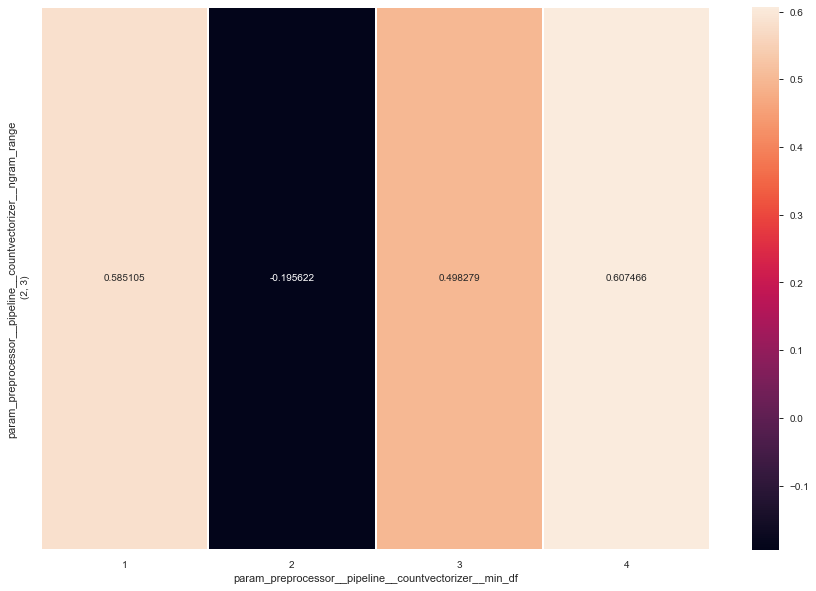

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df_grid = pd.DataFrame(grid.cv_results_).round(6)
df_grid
res = pd.pivot_table(df_grid,
    values='mean_test_score', index='param_preprocessor__pipeline__countvectorizer__ngram_range', columns='param_preprocessor__pipeline__countvectorizer__min_df')
ax = sns.heatmap(res, annot=True, linewidths=1, fmt="f")


The char gridsearch did not perform as well as our classic grid search and the normalizer doesn't seem to make any difference. Let's check out CharWb now.

CharWb Gridsearch

We limited our char_wb search to just the (2,3) ngram_range given the significant amount of time it was taking (over 1 day on our laptops)

In [10]:
proprocess_word = make_pipeline(
    CountVectorizer(ngram_range=(2, 3), analyzer="char_wb"),
    TfidfTransformer()
)

preprocess = make_column_transformer(
    (proprocess_word, 'all_text'),
)

In [11]:
pipe = Pipeline([('preprocessor', preprocess), ('normalizer', Normalizer()), ('regressor', LinearRegression())])
param_grid = [
    {
      "preprocessor__pipeline__countvectorizer__min_df": [1, 2, 3, 4],
      "normalizer": [None, Normalizer()]
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)  
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('countvectorizer',
                                                                                          CountVectorizer(analyzer='char_wb',
                                                                                                          binary=False,
                 

In [12]:
grid.best_score_

0.6245531438987874

In [13]:
grid.best_params_

{'normalizer': Normalizer(copy=True, norm='l2'),
 'preprocessor__pipeline__countvectorizer__min_df': 1}

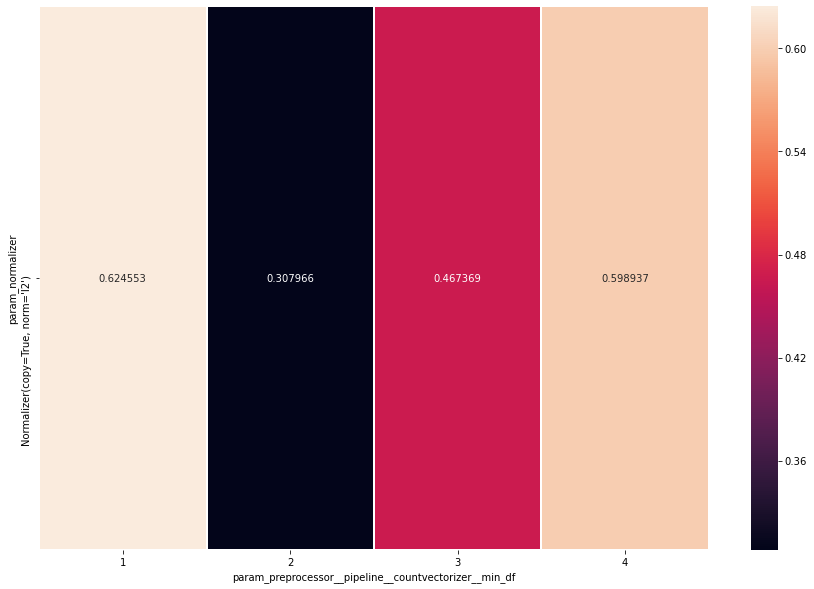

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df_grid = pd.DataFrame(grid.cv_results_).round(6)
df_grid
res = pd.pivot_table(df_grid,
    values='mean_test_score', index='param_normalizer', columns='param_preprocessor__pipeline__countvectorizer__min_df')
ax = sns.heatmap(res, annot=True, linewidths=1, fmt="f")


In [17]:
df_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_normalizer,param_preprocessor__pipeline__countvectorizer__min_df,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,201.564405,23.890337,4.991539,0.203135,None,1,"{'normalizer': None, 'preprocessor__pipeline__...",0.631269,0.644956,0.622675,...,0.624553,0.013221,2,0.848161,0.847533,0.848606,0.847334,0.848475,0.848022,0.000506
1,1132.681192,8.107374,5.215411,0.122992,None,2,"{'normalizer': None, 'preprocessor__pipeline__...",0.319506,0.309846,0.355625,...,0.307990,0.041095,7,0.847480,0.847017,0.848044,0.846379,0.847731,0.847330,0.000582
2,1007.138185,6.745905,4.938969,0.388348,None,3,"{'normalizer': None, 'preprocessor__pipeline__...",0.487330,0.488052,0.488261,...,0.467359,0.033678,6,0.843854,0.843121,0.843787,0.842587,0.844157,0.843501,0.000569
3,917.352092,60.558642,5.307758,0.510411,None,4,"{'normalizer': None, 'preprocessor__pipeline__...",0.606525,0.623490,0.606747,...,0.598937,0.021124,4,0.839798,0.838745,0.839433,0.838472,0.839653,0.839220,0.000520
4,215.631488,22.492651,5.828988,0.415322,"Normalizer(copy=True, norm='l2')",1,"{'normalizer': Normalizer(copy=True, norm='l2'...",0.631269,0.644956,0.622675,...,0.624553,0.013221,1,0.848161,0.847533,0.848606,0.847334,0.848475,0.848022,0.000506
5,1280.024901,33.587825,7.603752,1.743691,"Normalizer(copy=True, norm='l2')",2,"{'normalizer': Normalizer(copy=True, norm='l2'...",0.319436,0.309802,0.355658,...,0.307966,0.041112,8,0.847480,0.847017,0.848044,0.846379,0.847731,0.847330,0.000582
6,1185.328990,21.911462,6.446026,0.395796,"Normalizer(copy=True, norm='l2')",3,"{'normalizer': Normalizer(copy=True, norm='l2'...",0.487301,0.488049,0.488333,...,0.467369,0.033679,5,0.843854,0.843121,0.843787,0.842587,0.844157,0.843501,0.000569
7,934.615913,58.226786,5.598008,0.174149,"Normalizer(copy=True, norm='l2')",4,"{'normalizer': Normalizer(copy=True, norm='l2'...",0.606525,0.623490,0.606747,...,0.598937,0.021124,3,0.839798,0.838745,0.839433,0.838472,0.839653,0.839220,0.000520


The char_wb model performed slightly better than the char model, but still not as good as the classic model

### 1.4 Combine the non-text features and the text features. 
How does adding those features improve upon just using bag-of-words?

In [36]:
df['all_text'] = df['title'].astype(str) + " " +df['description'].astype(str)

In [37]:
y = df['points']

In [38]:
X = df.drop(columns=['country','points', 'taster_twitter_handle', 'description', 'title'])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [40]:
categorical = X_train.dtypes == 'object'

In [41]:
preprocess_continuous = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
preprocess_target = make_pipeline(
    TargetEncoder(),
)
preprocess_dummy = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore')
)

proprocess_word = make_pipeline(
    CountVectorizer(ngram_range=(1, 2), min_df = 1),
    TfidfTransformer()
)

In [42]:
preprocess = make_column_transformer(
    (preprocess_continuous, ~categorical),
    (preprocess_target, ['designation','region_1','variety','winery']),
    (preprocess_dummy, ['province','region_2','taster_name']),
    (proprocess_word, 'all_text'),
)

In [43]:
model_linear_regression = make_pipeline(preprocess, LinearRegression())

In [44]:
scores = cross_val_score(model_linear_regression, X_train, y_train)
np.mean(scores)

0.7672466043879365

In [45]:
model_linear_regression.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                           

In [46]:
model_linear_regression.score(X_test, y_test)

0.775435040275117

This is our best model so far, although the increase in score from adding the non-text features was modest. Let's explore what the most important features were.

In [47]:
continuous_feature_names = X_train.columns[~categorical].tolist()

In [80]:
target_feature_names = model_linear_regression.steps[0][1].transformers[1][2]

In [81]:
dummy_feature_names = model_linear_regression.steps[0][1].transformers_[2][1].steps[1][1].get_feature_names(['province','region_2','taster_name']).tolist()


In [72]:
all_text_feature_names = model_linear_regression.steps[0][1].transformers_[3][1].steps[0][1].get_feature_names()


In [73]:
all_text_feature_names = [('text_' + name) for name in all_text_feature_names]

In [82]:
feature_names = continuous_feature_names + target_feature_names + dummy_feature_names + all_text_feature_names


In [75]:
all_coef = model_linear_regression.steps[1][1].coef_

In [83]:
len(all_coef) == len(feature_names)

True

In [84]:
len(feature_names)

379232

In [85]:
len(all_coef)

379232

In [86]:
important = np.argsort(abs(all_coef))[-20:]

In [87]:
top20_feature = [feature_names[i] for i in important]
top20_coef = [all_coef[i] for i in important]

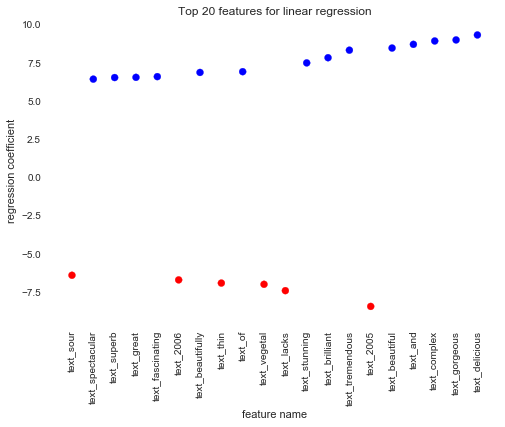

In [88]:
plt.scatter(top20_feature, top20_coef, c=np.sign(top20_coef), cmap='bwr_r')
plt.xticks(rotation='vertical')
plt.xlabel("feature name")
plt.ylabel("regression coefficient")
plt.title("Top 20 features for linear regression")
plt.show()

From this plot we can see that all the top features came from the count vectorizers which explains the limited influence of the non-text features. The top predictor of a high points was the appearance of the word "delicious" and the top predictor of low points was the appearance of the word "2005" which is interesting. Other high predictors of low points were the words "lacks" and "sour" which both make sense.